This notebook will be used to identify the best CEBRA model to use with our simple synethetic data

In [1]:
! pip install 'cebra[dev,demos]' 

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: No such file or directory
/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: exec: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: cannot execute: No such file or directory


In [13]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec
import cebra.datasets
from cebra import CEBRA
import d_library as dl
import sklearn.linear_model

from matplotlib.collections import LineCollection
import pandas as pd

## Define Input Data

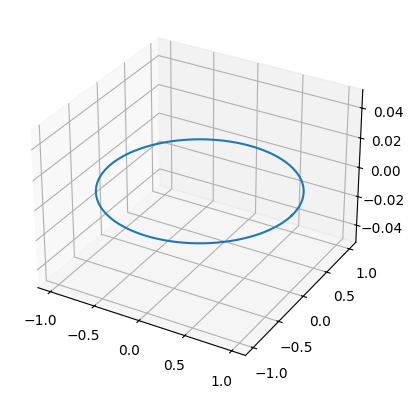

(100, 3)

In [3]:
%matplotlib inline
circle = dl.make_circle()
dl.plot_circle(circle[:,0], circle[:,1])
circle.shape

In [4]:
# define a function to make a lorenz system
def lorenz(t, xyz, sigma=10, rho=28, beta=8/3):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = rho * x - y - x * z
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]


# Define parameters and initial conditions
sigma = 10
rho = 28
beta = 8/3
initial_conditions = [0, 2, 0]  # Initial conditions for [x, y, z]

# Time span for integration
t_span = [0, 35]

# Solve the differential equations
solution = solve_ivp(lorenz, t_span, initial_conditions, args=(sigma, rho, beta), dense_output=True)

# Generate time points for plotting
t = np.linspace(t_span[0], t_span[1], 10000)

# Evaluate the solution at the time points
xyz = solution.sol(t)

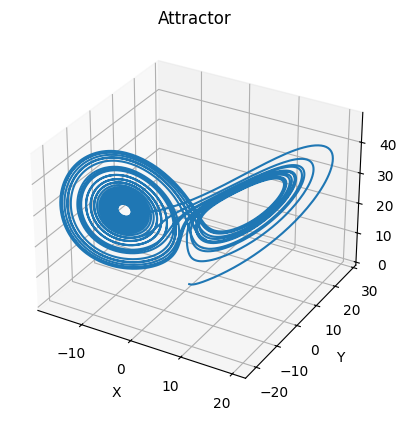

In [5]:
# Plot the Lorenz attractor
def plot_lorenz(coords):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(coords[0], coords[1], coords[2], alpha=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Attractor')
    plt.show()


plot_lorenz(xyz)

In [6]:
new_lorenz = np.transpose(xyz)

Define a function to make a linear regression of the true attractor and the embedding produced by CEBRA.

In [12]:
def reconstruction_score(x, y):

    def _linear_fitting(x, y):
        lin_model = sklearn.linear_model.LinearRegression()
        lin_model.fit(x, y)
        return lin_model.score(x, y), lin_model.predict(x)

    return _linear_fitting(x, y)

## Model Analysis
### 1. Offset1-model

We start with the offset1-model, detailing the steps of the analysis.

In [18]:
iterations = 2000

In [45]:
# build model and compute embedding
def base_embed_1(input, arch = 'offset1-model', temp=1, dimension=3, lr = 0.01, d=0.1):

    # build CEBRA time model
    model = CEBRA(model_architecture=arch,
                         batch_size=512,
                         learning_rate=int(lr),
                         temperature=int(temp),
                         output_dimension = int(dimension),
                         max_iterations=iterations,
                         delta=0.1,
                         distance='euclidean',
                         conditional='time',
                         device='cuda_if_available',
                         num_hidden_units=64,
                         verbose=True)

    model.fit(input)
    embedding = model.transform(input)
    return model, embedding

In [46]:
# get embeddings
model_1c, embedding_1c = base_embed_1(circle, lr=0.1)
model_1l, embeddling_1l = base_embed_1(new_lorenz, lr=0.01)

  0%|          | 0/2000 [00:00<?, ?it/s]

pos:  0.0000 neg:  6.2231 total:  6.2231 temperature:  1.0000: 100%|██████████| 2000/2000 [00:22<00:00, 90.68it/s]
pos:  0.0001 neg:  6.1243 total:  6.1244 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 93.09it/s]


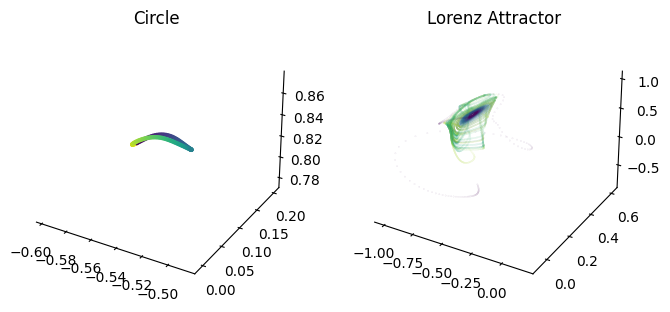

In [47]:
# plot the embeddings
def plot_2embeddings(embed1,embed2):
    fig0 = plt.figure(figsize=(8,4))
    gs = gridspec.GridSpec(1, 2, figure=fig0)

    ax0 = fig0.add_subplot(gs[0,0], projection='3d')
    ax1 = fig0.add_subplot(gs[0,1], projection='3d')
    cebra.plot_embedding(embed1, embedding_labels='time', ax=ax0, markersize=5, alpha=1, title='Circle')
    cebra.plot_embedding(embed2, embedding_labels='time',ax=ax1, markersize=0.001, alpha=1, title='Lorenz Attractor')

plot_2embeddings(embedding_1c, embeddling_1l)

In [48]:
score_, t_embedding = reconstruction_score(embeddling_1l, new_lorenz)

In [49]:
score_

0.6151599110625333

<Axes3D: title={'center': 'Embedding'}>

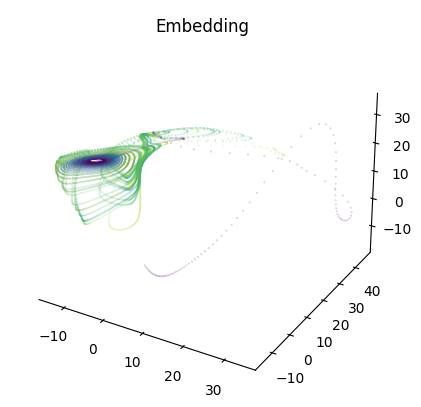

In [50]:
cebra.plot_embedding(t_embedding, embedding_labels='time')

Ok, so even after getting the linear regression version it's still not accurate.


### 2. offset1-model-mse

We analyse the next model, this time combining all the steps into a single function.
We also add a section to check if the loss and temperature of the model converge(excluded plots on temperature and loss convergence because we only want to see the general trend in the embeddings -- plus they don't yet converge in this notebook).

In [64]:
def view_model(model_name, n_iterations=1):

    # define grid
    fig0 = plt.figure(figsize=(8,4*n_iterations))
    gs = gridspec.GridSpec(n_iterations, 2, figure=fig0)

    # output the best transformed embedding
    best_transf = None
    best_score = 0

    # for each iteration
    for i in range(0,n_iterations):

        # create models and compute embeddings
        model_c, embedding_c = base_embed_1(circle, arch=model_name, lr=0.1)
        model_l, embedding_l = base_embed_1(new_lorenz, arch=model_name, lr=0.01)

        score, t_embed = reconstruction_score(embedding_l, new_lorenz)

        # plot the embeddings
        ax0 = fig0.add_subplot(gs[i,0], projection='3d')
        ax1 = fig0.add_subplot(gs[i,1], projection='3d')
        cebra.plot_embedding(embedding_c, embedding_labels='time', ax=ax0, markersize=5, alpha=1, title='Circle')
        cebra.plot_embedding(embedding_l, embedding_labels='time',ax=ax1, markersize=0.001, alpha=1, title=f'Lorenz Attractor: {np.round(score,3)}')

        # update the champion embedding and score
        if score > best_score:
            best_transf = t_embed
            best_score = score

    fig0.suptitle('{}'.format(model_name))
    
    return best_transf

pos:  0.0000 neg:  6.2382 total:  6.2382 temperature:  1.0000: 100%|██████████| 2000/2000 [00:20<00:00, 95.39it/s] 
pos:  0.0003 neg:  5.8304 total:  5.8307 temperature:  1.0000: 100%|██████████| 2000/2000 [00:19<00:00, 101.44it/s]


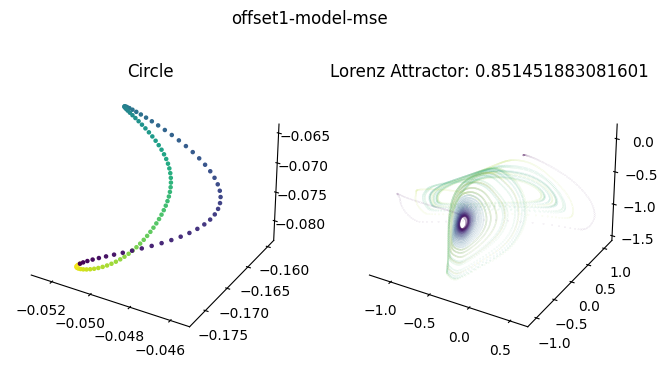

In [56]:
t_embed = view_model('offset1-model-mse')

<Axes3D: title={'center': 'Embedding'}>

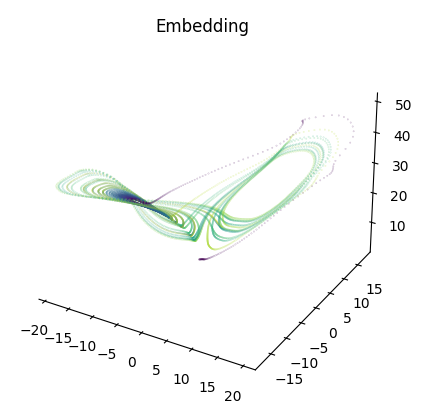

In [58]:
cebra.plot_embedding(t_embed, embedding_labels='time')

Ok so this model is definitely out-performing the offset1-model because it has a higher reconstruction score and the embedding looks more accurate than before.

### 3. Offset 10-model 

pos:  0.0023 neg:  5.6402 total:  5.6425 temperature:  1.0000: 100%|██████████| 2000/2000 [00:32<00:00, 61.96it/s]
pos:  0.0001 neg:  6.0692 total:  6.0693 temperature:  1.0000: 100%|██████████| 2000/2000 [00:30<00:00, 65.47it/s]
pos:  0.0051 neg:  5.1721 total:  5.1772 temperature:  1.0000: 100%|██████████| 2000/2000 [00:30<00:00, 64.77it/s]
pos:  0.0000 neg:  6.1810 total:  6.1810 temperature:  1.0000: 100%|██████████| 2000/2000 [00:31<00:00, 64.39it/s]


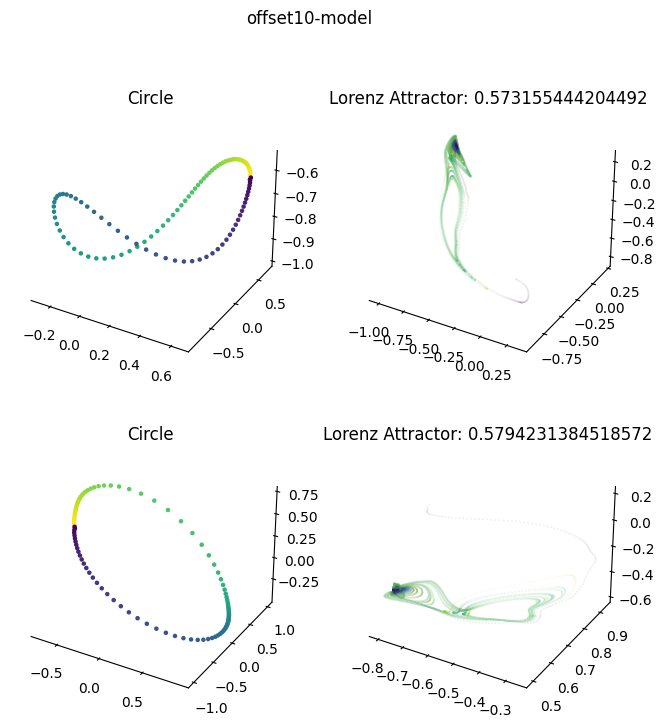

In [63]:
t_embed_10 = view_model('offset10-model', n_iterations=2)

Performance is not as good as the offset1-model-mse model or the offset1-model

### 4. All Models

We now make a summary function to analyse all the predefined CEBRA models.

In [14]:
cebra.models.get_options()

['offset10-model',
 'offset10-model-mse',
 'offset5-model',
 'offset1-model-mse',
 'offset1-model',
 'offset1-model-v2',
 'offset1-model-v3',
 'offset1-model-v4',
 'offset1-model-v5',
 'offset40-model-4x-subsample',
 'resample-model',
 'offset20-model-4x-subsample',
 'resample5-model',
 'offset4-model-2x-subsample',
 'resample1-model',
 'supervised10-model',
 'supervised1-model',
 'offset36-model',
 'offset36-model-dropout',
 'offset36-model-more-dropout']

In [15]:
save_dir = os.getcwd()

In [16]:
# takes in  number of iterations for each model
def analyse_models(iter=3):

    # get a list of all the models
    list = cebra.models.get_options()[17:]

    # view the embeddings produced by each model
    for model in list:
        view_model(model_name=model, n_iterations=int(iter))
        plt.savefig(save_dir + os.sep + model + ".png")

pos:  0.0089 neg:  5.3422 total:  5.3511 temperature:  1.0000: 100%|██████████| 2000/2000 [01:24<00:00, 23.77it/s]
pos:  0.0006 neg:  6.2269 total:  6.2275 temperature:  1.0000: 100%|██████████| 2000/2000 [01:24<00:00, 23.65it/s]
pos:  0.0012 neg:  5.8966 total:  5.8979 temperature:  1.0000: 100%|██████████| 2000/2000 [01:25<00:00, 23.42it/s]
pos:  0.0050 neg:  6.1349 total:  6.1400 temperature:  1.0000: 100%|██████████| 2000/2000 [01:41<00:00, 19.79it/s]
pos:  0.0015 neg:  5.5951 total:  5.5966 temperature:  1.0000: 100%|██████████| 2000/2000 [01:40<00:00, 19.81it/s]
pos:  0.0079 neg:  6.0902 total:  6.0981 temperature:  1.0000: 100%|██████████| 2000/2000 [01:41<00:00, 19.77it/s]
pos:  0.0017 neg:  5.6265 total:  5.6282 temperature:  1.0000: 100%|██████████| 2000/2000 [01:41<00:00, 19.66it/s]
pos:  0.0039 neg:  6.2075 total:  6.2114 temperature:  1.0000: 100%|██████████| 2000/2000 [01:41<00:00, 19.68it/s]
pos:  0.0002 neg:  6.1438 total:  6.1440 temperature:  1.0000: 100%|██████████| 

KeyboardInterrupt: 

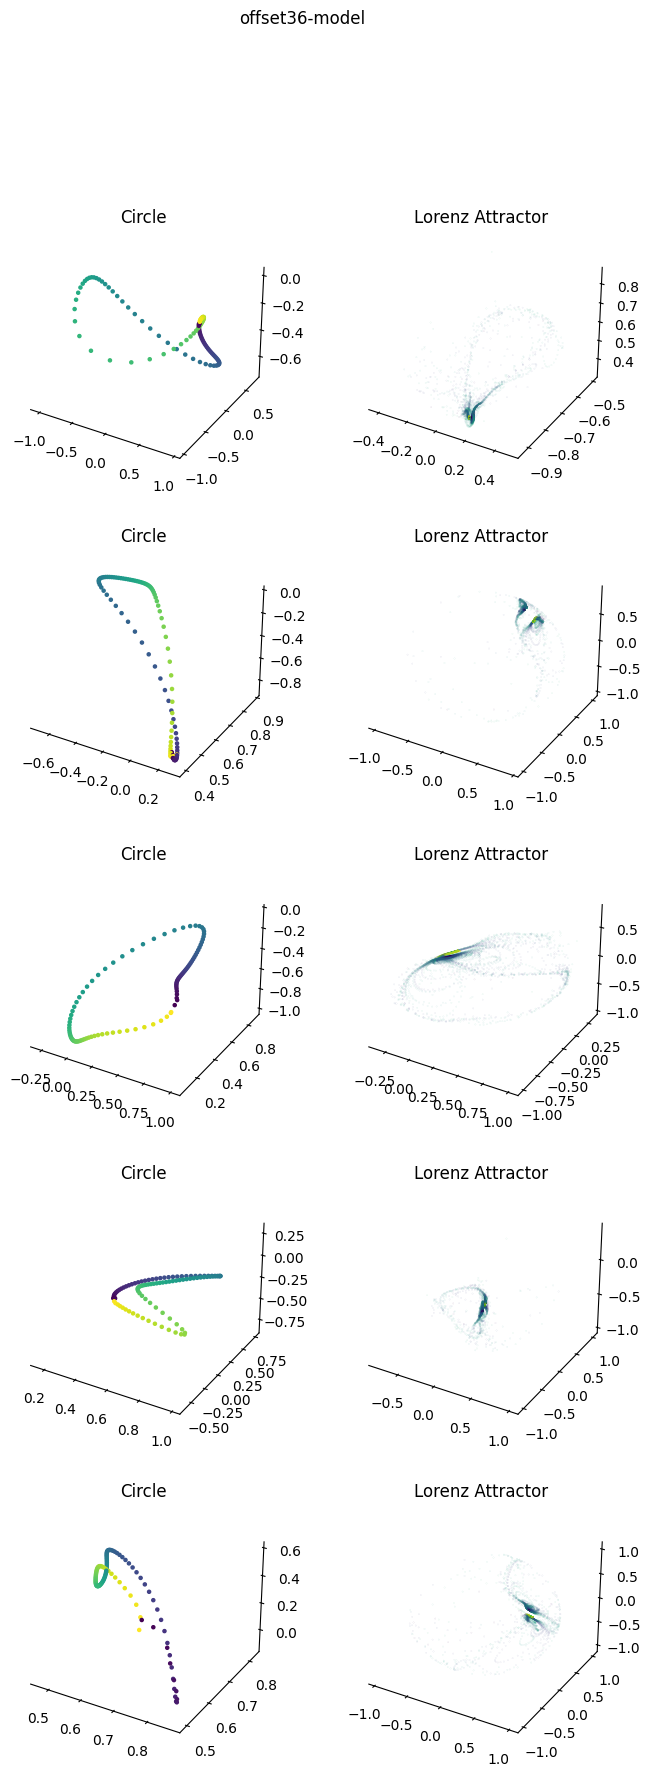

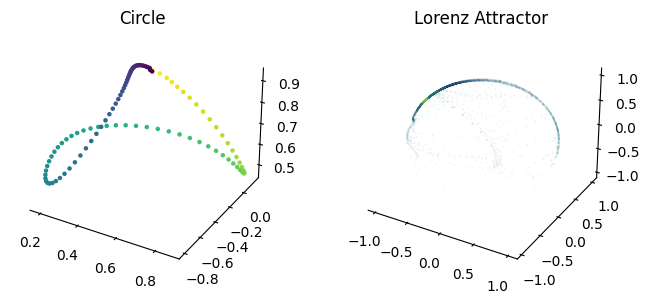

In [17]:
analyse_models()

On subjective viewing of the embeddings produced by the different model architectures, some have stood out for different reasons:

- offset1-model, offset1-model-mse, offset5-model, offset10-model-mse, offset36-model: for recovering the circles (comparatively) consistently
- offset10-model, offset-model: for recovering the circles consistently and getting almost plausible representations of the lorenz attractor.